In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
data = pd.read_csv('../input/ids-intrusion-csv/02-14-2018.csv')
data.tail()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048574,443,6,14/02/2018 10:53:28,5807256,6,4,327,145,245,0,...,20,291569.0,0.0,291569,291569,5515650.0,0.0,5515650,5515650,Benign


In [3]:
data['Label'].unique()

array(['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], dtype=object)

In [4]:

data["Label"] = np.where(data["Label"] != "Benign", 'malicious','normal')

In [5]:

print(data.columns[data.isnull().any()])

Index(['Flow Byts/s'], dtype='object')


In [6]:

data = data.dropna(axis=0);

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046298 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1046298 non-null  int64  
 1   Protocol           1046298 non-null  int64  
 2   Timestamp          1046298 non-null  object 
 3   Flow Duration      1046298 non-null  int64  
 4   Tot Fwd Pkts       1046298 non-null  int64  
 5   Tot Bwd Pkts       1046298 non-null  int64  
 6   TotLen Fwd Pkts    1046298 non-null  int64  
 7   TotLen Bwd Pkts    1046298 non-null  int64  
 8   Fwd Pkt Len Max    1046298 non-null  int64  
 9   Fwd Pkt Len Min    1046298 non-null  int64  
 10  Fwd Pkt Len Mean   1046298 non-null  float64
 11  Fwd Pkt Len Std    1046298 non-null  float64
 12  Bwd Pkt Len Max    1046298 non-null  int64  
 13  Bwd Pkt Len Min    1046298 non-null  int64  
 14  Bwd Pkt Len Mean   1046298 non-null  float64
 15  Bwd Pkt Len Std    1046298 non-n

In [8]:

le = LabelEncoder()
data['Timestamp']=le.fit_transform(data['Timestamp'])
data['Label']=le.fit_transform(data['Label'])

In [9]:

print(False in np.isfinite(data).values)

True


In [10]:

data = data[np.isfinite(data).all(1)]

In [11]:

data.describe()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,...,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06
mean,4.711645e+03,8.115271e+00,1.776855e+04,6.278451e+06,6.222033e+00,7.237526e+00,4.495806e+02,4.538354e+03,1.751610e+02,8.418147e+00,...,2.329159e+01,5.171308e+04,2.143970e+04,8.821327e+04,4.010102e+04,3.112557e+06,7.323927e+05,4.830005e+06,2.134705e+06,6.353744e-01
std,1.420505e+04,4.466955e+00,9.369674e+03,1.262595e+09,4.455911e+01,1.050590e+02,1.576416e+04,1.517789e+05,2.880300e+02,1.951045e+01,...,1.108023e+01,5.826136e+05,2.190364e+05,7.409056e+05,5.612885e+05,5.424680e+08,3.827015e+08,1.524900e+09,1.820290e+07,4.813253e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.200000e+01,6.000000e+00,7.766000e+03,7.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.300000e+01,6.000000e+00,2.040100e+04,1.040000e+03,2.000000e+00,1.000000e+00,3.600000e+01,5.600000e+01,3.500000e+01,0.000000e+00,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,4.430000e+02,6.000000e+00,2.589700e+04,4.087895e+05,8.000000e+00,6.000000e+00,4.550000e+02,7.880000e+02,2.010000e+02,0.000000e+00,...,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,6.553300e+04,1.700000e+01,3.204200e+04,1.200000e+08,5.115000e+03,9.198000e+03,8.591554e+06,1.339773e+07,6.444000e+04,1.460000e+03,...,4.800000e+01,1.102401e+08,5.723446e+07,1.102401e+08,1.102401e+08,3.394503e+11,2.432682e+11,9.797810e+11,1.260300e+10,1.000000e+00


### Train Test Split:

In [12]:
x = data.drop(['Label'] , axis = 1).values
y = data['Label'].values

In [13]:

ro_scaler = RobustScaler()
x_scaled = ro_scaler.fit_transform(x)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_scaled)

In [14]:
x_train , x_test , y_train , y_test = train_test_split(x_scaled, y, test_size= 0.2 , random_state=42)

In [15]:
x_train.shape, x_test.shape

((835800, 79), (208951, 79))

In [16]:
def cross_val(x_train, y_train, model):
    accuracies = cross_val_score(estimator = model, X = x_train, y = y_train, cv=5)
    return accuracies.mean()

def fit_and_evaluate(model, x_train , x_test , y_train , y_test):
    model.fit(x_train, y_train)

    model_pred = model.predict(x_test)
    model_cross = cross_val(x_train, y_train, model)
    
    return model_cross

def run_experiment(model, x_train , x_test , y_train , y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    report=classification_report(y_test,y_pred)
    print(report)

## Logistic Regression:

In [17]:
x_traincpy = np.copy(x_train)
y_traincpy = np.copy(y_train)
x_testcpy = np.copy(x_test)
y_testcpy = np.copy(y_test)

logr = LogisticRegression()
logr_cross = fit_and_evaluate(logr, x_traincpy , x_testcpy , y_traincpy , y_testcpy)

print('Logistic Regression Performance on the test set: Cross Validation Score = %0.4f' % logr_cross)

model = LogisticRegression()
run_experiment(model, x_traincpy , x_testcpy , y_traincpy , y_testcpy)

Logistic Regression Performance on the test set: Cross Validation Score = 0.9994
R^2 :  0.9977072320908189
MAE : 0.0005312250240487004
RMSE: 0.023048319332409042
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76206
           1       1.00      1.00      1.00    132745

    accuracy                           1.00    208951
   macro avg       1.00      1.00      1.00    208951
weighted avg       1.00      1.00      1.00    208951



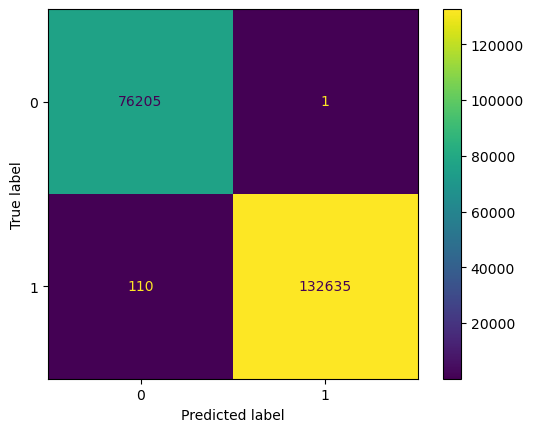

Accuracy:  0.9994687749759513


In [18]:
y_pred = model.predict(x_testcpy)
cm = confusion_matrix(y_testcpy, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
print("Accuracy: ", accuracy_score(y_testcpy, y_pred))

## Random Forest:

In [19]:
x_traincpy = np.copy(x_train)
y_traincpy = np.copy(y_train)
x_testcpy = np.copy(x_test)
y_testcpy = np.copy(y_test)

random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
random_cross = fit_and_evaluate(random, x_traincpy , x_testcpy , y_traincpy , y_testcpy)

print('Random Forest Performance on the test set: Cross Validation Score = %0.4f' % random_cross)

Random Forest Performance on the test set: Cross Validation Score = 1.0000


In [20]:
y_pred = random.predict(x_testcpy)
print("Accuracy: ", accuracy_score(y_testcpy, y_pred))

Accuracy:  1.0


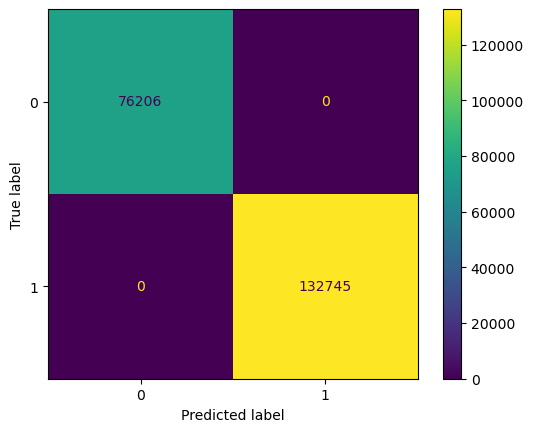

In [21]:
cm = confusion_matrix(y_testcpy, y_pred, labels=random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random.classes_)
disp.plot()
plt.show()

## Decision Tree:

In [22]:
x_traincpy = np.copy(x_train)
y_traincpy = np.copy(y_train)
x_testcpy = np.copy(x_test)
y_testcpy = np.copy(y_test)

DT=DecisionTreeClassifier()
DT_cross = fit_and_evaluate(DT, x_traincpy , x_testcpy , y_traincpy , y_testcpy)

print('Decision Tree Performance on the test set: Cross Validation Score = %0.4f' % DT_cross)

Decision Tree Performance on the test set: Cross Validation Score = 1.0000


In [23]:
y_pred = DT.predict(x_testcpy)
print("Accuracy: ", accuracy_score(y_testcpy, y_pred))

Accuracy:  1.0


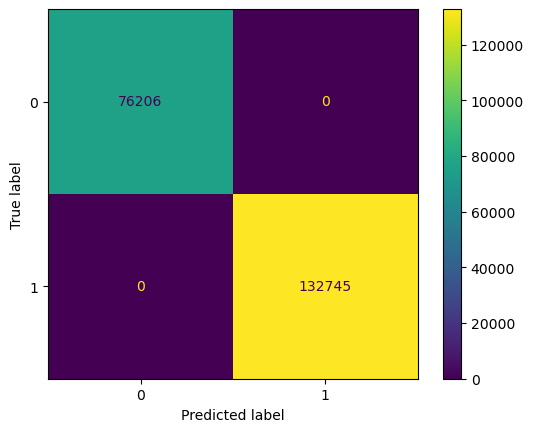

In [24]:
cm = confusion_matrix(y_testcpy, y_pred, labels=DT.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DT.classes_)
disp.plot()
plt.show()

## RNN:

In [25]:
x_train_srnn = np.copy(x_train)
x_test_srnn = np.copy(x_test)
y_train_srnn = np.copy(y_train)
y_test_srnn = np.copy(y_test)

In [26]:
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(x_train_srnn.shape[1], 1), return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=False))
model.add(Dense(units=1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 79, 64)            4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 79, 64)            8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/3
6530/6530 [==============================] - 574s 87ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.0055 - val_accuracy: 0.9990
Epoch 2/3
6530/6530 [==============================] - 606s 93ms/step - loss: 0.2754 - accuracy: 0.8257 - val_loss: 0.5541 - val_accuracy: 0.6353
Epoch 3/3
6530/6530 [==============================] - 575s 88ms/step - loss: 0.4716 - accuracy: 0.6950 - val_loss: 0.0161 - val_accuracy: 0.9972


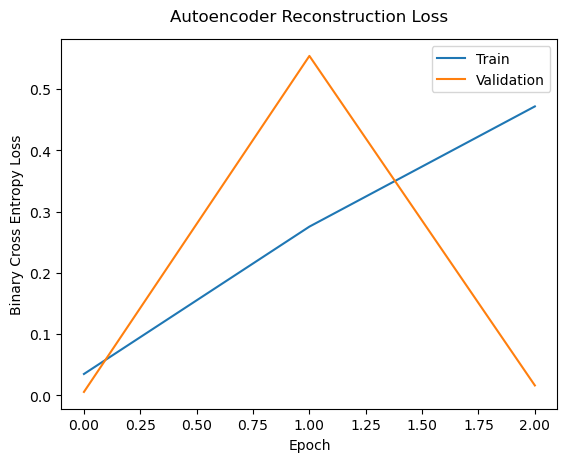

In [29]:
history = model.fit(x_train_srnn.reshape((x_train_srnn.shape[0], x_train_srnn.shape[1], 1)), y_train_srnn, epochs=3, batch_size=128,
                    validation_data=(x_test_srnn.reshape((x_test_srnn.shape[0], x_test_srnn.shape[1], 1)), y_test_srnn))
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Autoencoder Reconstruction Loss', pad=13)
plt.legend(loc='upper right')

In [30]:
srnn_y_pred = model.predict(x_test_srnn.reshape((x_test_srnn.shape[0], x_test_srnn.shape[1], 1)))
srnn_y_pred = (srnn_y_pred > 0.5)
print("Accuracy:", accuracy_score(y_test_srnn, srnn_y_pred))

6530/6530 [==============================] - 124s 19ms/step
Accuracy: 0.9972338012261248
